In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

## Sample SQL queries

```sql
SELECT *
FROM movie_companies AS mc
INNER JOIN title AS tO N t.id = mc.movie_id
INNER JOIN movie_info_idx AS mi_idx
    ON t.id = mi_idx.movie_id
WHERE mi_idx.info_type_id = 113
    AND mc.company_type_id = 2
    AND t.production_year > 1880
    AND t.production_year < 1967
```

```sql
SELECT *
FROM movie_companies AS mc
INNER JOIN title AS tO N t.id = mc.movie_id
INNER JOIN movie_info_idx AS mi_idx
    ON t.id = mi_idx.movie_id
WHERE mi_idx.info_type_id = 113
    AND mc.company_type_id = 2
    AND t.production_year > 1880
    AND t.production_year < 1968
```

## Plots

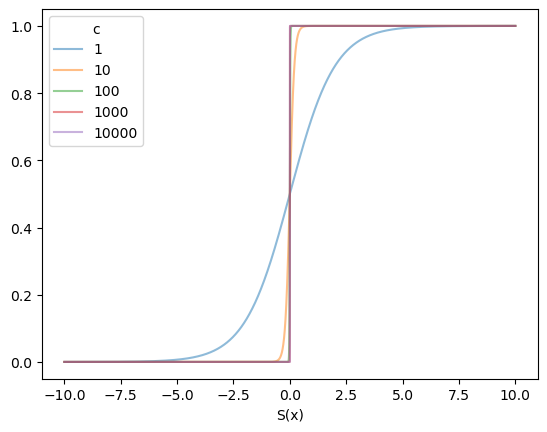

In [6]:
# plot a motivation figure for soft sign

fig, ax = plt.subplots(1, 1)
x_vals = np.linspace(-10, 10, 10001)

def stable_c_sigmoid(x, c):
    if x >= 0:
        return 1/(1 + np.exp(-1 * c * x))
    else:
        return np.exp(c * x)/(1 + np.exp(c * x))

for c in [1, 10, 100, 1000, 10000]:

    y_vals = [stable_c_sigmoid(x, c) for x in x_vals]
    ax.plot(x_vals, y_vals, label=str(c), alpha=0.5)

ax.legend(title="c")
plt.xlabel('x')
plt.xlabel('S(x)')
plt.savefig('figures/c_sigmoid_plot.pdf')

## load grid search results

In [13]:
gs_result = list()

gs_dir = os.path.join('logs', 'grid_search')
for sub_dir in os.listdir(gs_dir):
    full_dir_path = os.path.join(gs_dir, sub_dir)
    if os.path.isdir(full_dir_path):
        with open(os.path.join(full_dir_path, 'config.json'), "r") as fin:
            config_dict = json.load(fin)
        with open(os.path.join(full_dir_path, 'eval.json'), "r") as fin:
            eval_dict = json.load(fin)
        join = dict()
        for target in [config_dict, eval_dict]:
            for k, v in target.items():
                join[k] = v
        # add MonoM more stats
        monom_df = pd.read_csv(os.path.join(full_dir_path, 'test_monom.csv'))
        join['monom_std'] = np.std(monom_df.MonoM.values)
        join['monom_10'] = np.percentile(monom_df.MonoM.values, 10)
        join['monom_25'] = np.percentile(monom_df.MonoM.values, 25)
        join['monom_75'] = np.percentile(monom_df.MonoM.values, 75)
        join['monom_90'] = np.percentile(monom_df.MonoM.values, 90)
        # add Q-error more stats
        qerror_df = pd.read_csv(os.path.join(full_dir_path, 'test_qerror.csv'))
        join['qerror_std'] = np.std(qerror_df.qerror.values)
        gs_result.append(join)

gs_result = pd.DataFrame(gs_result)

In [14]:
gs_result.head()

,testset,num_train_queries,epochs,batch_size,num_hidden_units,cuda,lbda,qerror_median,qerror_mean,qerror_10,...,monom_mean,monom_std,monom_10,monom_25,monom_75,monom_90,qerror_std,regbatch,reg_dist_metric,soften
0,job-cmp-card,50000,50,1024,512,True,0.0,3.313800,206.842162,1.236106,...,0.916450,0.276712,1.0,1.0,1.0,1.0,4232.485072,NaN,NaN,NaN
1,job-cmp-card,50000,50,1024,128,True,1.0,9.866667,103.801498,2.016579,...,0.917947,0.274446,1.0,1.0,1.0,1.0,1200.364061,1024.0,jaccard,10000.0
2,job-cmp-card,50000,50,1024,512,True,1.0,7.849592,263.259719,1.238815,...,0.888915,0.314237,0.0,1.0,1.0,1.0,1126.553971,1024.0,diff,1000.0
3,job-cmp-card,50000,50,1024,128,True,0.1,5.786039,291.062725,1.491351,...,0.915255,0.278502,1.0,1.0,1.0,1.0,10478.417766,1024.0,jaccard,1000.0
4,job-cmp-card,50000,50,1024,256,True,10.0,6.244114,106.471856,1.277893,...,0.912905,0.281975,1.0,1.0,1.0,1.0,1730.463190,1024.0,diff,100.0


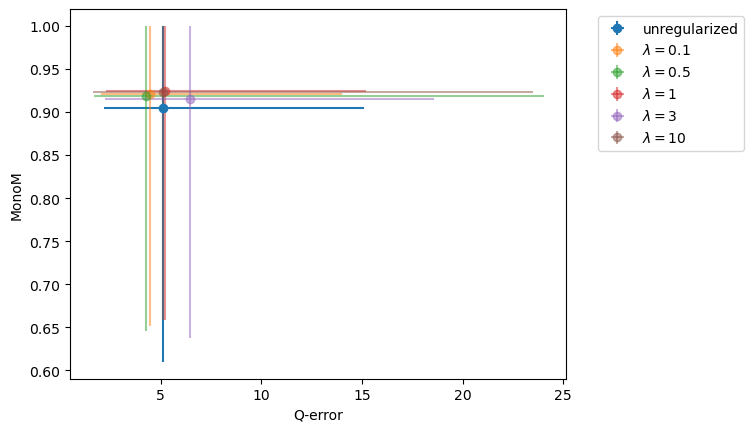

In [59]:
# scatter plot

fig, ax = plt.subplots(1, 1)

unregularized_df = gs_result[gs_result.lbda == 0.0]
regularized_df = gs_result[gs_result.lbda != 0.0]

# for unregularized results, plot the default configuration from the paper
selected_row = unregularized_df[unregularized_df.num_hidden_units == 256].iloc[0]
ax.errorbar(
    selected_row['qerror_median'], selected_row['monom_mean'],
    xerr=[
        [selected_row['qerror_median'] - selected_row['qerror_25']],
        [selected_row['qerror_75'] - selected_row['qerror_median']]
    ],
    yerr=[
        [min(selected_row['monom_std'], selected_row['monom_mean'])],
        [min(selected_row['monom_std'], 1 - selected_row['monom_mean'])]
    ],
    label='unregularized',
    fmt='o'
)

# for regularized results, plot 256 hidden units, and for each lambda = 0.1, 1, 10,
# plot the one with the best mean monom score
for lbda in [0.1, 1, 10]:
    sub_df = regularized_df[(regularized_df.lbda == lbda) & (regularized_df.num_hidden_units == 256)]
    max_monom = np.amax(sub_df.monom_mean.values)
    selected_row = sub_df[sub_df.monom_mean == max_monom].iloc[0]
    ax.errorbar(
        selected_row['qerror_median'], selected_row['monom_mean'],
        xerr=[
            [selected_row['qerror_median'] - selected_row['qerror_25']],
            [selected_row['qerror_75'] - selected_row['qerror_median']]
        ],
        yerr=[
            [min(selected_row['monom_std'], selected_row['monom_mean'])],
            [min(selected_row['monom_std'], 1 - selected_row['monom_mean'])]
        ],
        label='$\lambda={}$'.format(lbda),
        fmt='o',
        alpha=0.5
    )

ax.set_xlabel('Q-error')
ax.set_ylabel('MonoM')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.savefig('figures/overall_eval.pdf', bbox_inches='tight')